In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Constants
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()

GPIO.setmode(GPIO.BCM)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c

"""
- gear ratio = 75:1 = motor shaft rotates 75 times each revolution
- encoder = 48 CPR (count per revolution) = 48 counts each shaft rotation
- counts per round = count per rev * rev per round = 48*75 = 3600
"""
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 17 # IN1 10
ML_IN2 = 27 # IN2 22
ML_ENA = 11 # brown 9

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9

# Physical dimensions
WHEEL_RADIUS = 0.056 # meters
WHEEL_SEP = 0.222 # meters


/tmp/ipykernel_1471/1530775278.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


In [3]:

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position
        self.y = 0.0  # y-position 
        self.th = 0.0  # orientation
        
        self.wl = 0.0  # rotational velocity left wheel
        self.wr = 0.0  # rotational velocity right wheel
        
        self.dt = dt # time delta in seconds
        self.r = wheel_radius # wheel radius in meters
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. 
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
        

    def read_wheel_velocities(self, dt=None):
        if not dt:
            dt = self.dt
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = (ml_enc_now - self.ml_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        mr_enc_delta = (mr_enc_now - self.mr_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        
        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / dt
        self.wr = mr_delta_rad / dt

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  

    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)

        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)

    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0
        w = (wl * self.r - wr * self.r) / self.l
        return v, w

    def pose_update(self, duty_cycle_ml, duty_cycle_mr, dt=None):
        if not dt:
            dt = self.dt
            
        self.set_motor_speed(duty_cycle_ml, duty_cycle_mr)
        wl, wr = self.read_wheel_velocities() # get wheel velocities 
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + dt * v * np.cos(self.th)
        self.y = self.y + dt * v * np.sin(self.th)
        self.th = self.th + w * dt
        
        return self.x, self.y, self.th

    
class RobotController:
    
    def __init__(self,Kp=0.2,Ki=0.0,wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self, w_desired, w_measured, e_sum, dt):
        error = w_desired - w_measured
        p_term = self.Kp * error
        i_term = self.Ki * e_sum * dt  # Note: Integrate error over time
        duty_cycle = min(max(-1, p_term + i_term), 1)
        e_sum = e_sum + error * dt  # Accumulate error over actual time
        
        return duty_cycle, e_sum
        
        
    def drive(self, v_desired, w_desired, wl, wr, dt):
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired, wl, self.e_sum_l, dt)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired, wr, self.e_sum_r, dt)
        
        return duty_cycle_l, duty_cycle_r

In [4]:
GPIO.setwarnings(False)
robot = DiffDriveRobot()

v_des: 0.50, w_des: 0.10, v_actual: 0.00, w_actual: 0.00
duty cycle l: 1, r: 1
Position: (0.00, 0.00), Orientation: 0.00

v_des: 0.50, w_des: 0.10, v_actual: 0.00, w_actual: 0.00
duty cycle l: 1, r: 1
Position: (0.01, 0.00), Orientation: -0.01

v_des: 0.50, w_des: 0.10, v_actual: 0.80, w_actual: 1.01
duty cycle l: 1, r: 1
Position: (0.01, -0.00), Orientation: -0.02

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.59
duty cycle l: 1, r: 1
Position: (0.02, -0.00), Orientation: -0.03

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.59
duty cycle l: 1, r: 1
Position: (0.03, -0.00), Orientation: -0.04

v_des: 0.50, w_des: 0.10, v_actual: 1.22, w_actual: 1.68
duty cycle l: 1, r: 1
Position: (0.04, -0.00), Orientation: -0.05

v_des: 0.50, w_des: 0.10, v_actual: 1.24, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.05, -0.00), Orientation: -0.06

v_des: 0.50, w_des: 0.10, v_actual: 1.33, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.05, -0.00), Orientation: -0.07

v_des: 0.50

v_des: 0.50, w_des: 0.10, v_actual: 1.29, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.51, -0.19), Orientation: -0.72

v_des: 0.50, w_des: 0.10, v_actual: 1.20, w_actual: 1.64
duty cycle l: 1, r: 1
Position: (0.52, -0.19), Orientation: -0.73

v_des: 0.50, w_des: 0.10, v_actual: 1.19, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.53, -0.20), Orientation: -0.74

v_des: 0.50, w_des: 0.10, v_actual: 1.19, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.53, -0.21), Orientation: -0.75

v_des: 0.50, w_des: 0.10, v_actual: 1.27, w_actual: 1.68
duty cycle l: 1, r: 1
Position: (0.54, -0.21), Orientation: -0.76

v_des: 0.50, w_des: 0.10, v_actual: 1.31, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.54, -0.22), Orientation: -0.77

v_des: 0.50, w_des: 0.10, v_actual: 1.22, w_actual: 1.64
duty cycle l: 1, r: 1
Position: (0.55, -0.22), Orientation: -0.78

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.64
duty cycle l: 1, r: 1
Position: (0.56, -0.23), Orientation: -0.80

v_des: 0

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.64
duty cycle l: 1, r: 1
Position: (0.77, -0.67), Orientation: -1.47

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.77, -0.68), Orientation: -1.48

v_des: 0.50, w_des: 0.10, v_actual: 1.22, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.77, -0.69), Orientation: -1.49

v_des: 0.50, w_des: 0.10, v_actual: 1.26, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.77, -0.70), Orientation: -1.50

v_des: 0.50, w_des: 0.10, v_actual: 1.29, w_actual: 1.68
duty cycle l: 1, r: 1
Position: (0.77, -0.71), Orientation: -1.51

v_des: 0.50, w_des: 0.10, v_actual: 1.19, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.77, -0.72), Orientation: -1.52

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.66
duty cycle l: 1, r: 1
Position: (0.77, -0.72), Orientation: -1.54

v_des: 0.50, w_des: 0.10, v_actual: 1.17, w_actual: 1.64
duty cycle l: 1, r: 1
Position: (0.77, -0.73), Orientation: -1.55

v_des: 0

v_des: 0.50, w_des: 0.10, v_actual: 1.15, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.63, -1.19), Orientation: -2.24

v_des: 0.50, w_des: 0.10, v_actual: 1.15, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.62, -1.20), Orientation: -2.25

v_des: 0.50, w_des: 0.10, v_actual: 1.13, w_actual: 1.55
duty cycle l: 1, r: 1
Position: (0.62, -1.20), Orientation: -2.26

v_des: 0.50, w_des: 0.10, v_actual: 1.20, w_actual: 1.62
duty cycle l: 1, r: 1
Position: (0.61, -1.21), Orientation: -2.27

v_des: 0.50, w_des: 0.10, v_actual: 1.24, w_actual: 1.61
duty cycle l: 1, r: 1
Position: (0.61, -1.21), Orientation: -2.28

v_des: 0.50, w_des: 0.10, v_actual: 1.19, w_actual: 1.57
duty cycle l: 1, r: 1
Position: (0.60, -1.22), Orientation: -2.29

v_des: 0.50, w_des: 0.10, v_actual: 1.13, w_actual: 1.61
duty cycle l: 1, r: 1
Position: (0.59, -1.23), Orientation: -2.30

v_des: 0.50, w_des: 0.10, v_actual: 1.12, w_actual: 1.55
duty cycle l: 1, r: 1
Position: (0.59, -1.23), Orientation: -2.32

v_des: 0

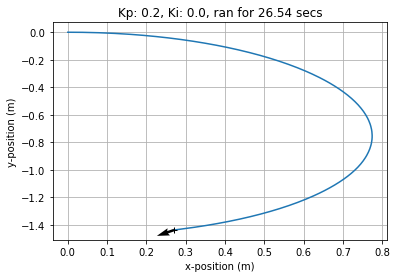

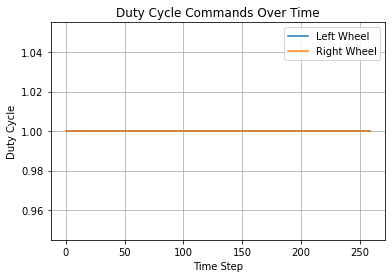

In [5]:
# Main control loop
from IPython import display


# Parameters
Kp = 0.2
Ki = 0.0

# Initialising
controller = RobotController(Kp, Ki)

poses = []
velocities = []
duty_cycle_commands = []


# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.5
w_desired = 0.0

start_time, last_time = time.time(), time.time()

try:
    while True: 
        current_time = time.time()
        actual_dt = current_time - last_time

        duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)
        print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}, v_actual: {robot.wl:.2f}, w_actual: {robot.wr:.2f}")
        print(f"duty cycle l: {duty_cycle_l}, r: {duty_cycle_r}")
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
        
        # Log data
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        
        print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")
        
        last_time = current_time
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time
    # Plot robot data
#     plt.clf()
#     plt.cla()
    plt.figure()
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
    plt.grid()
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

    plt.figure()
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
#     display.display(plt.gcf())

#     GPIO.cleanup()

    


In [6]:
# duty_cycle_ml, duty_cycle_mr = controller.drive(0.5, 0, robot.wl, robot.wr)
# print(f"{duty_cycle_ml}, {duty_cycle_mr}")


# Some code that helps you to see if encoder calculations / odometry is working


OPTION = 0


if OPTION==1:
    robot.set_motor_speed(1, 0)


poses = []
velocities = []
duty_cycle_commands = []

if OPTION != 0:
    try:
        while True:
            if OPTION == 1:
                print(f"l: {robot.ML_ENC.steps}, r: {robot.MR_ENC.steps}")
                wl, wr = robot.read_wheel_velocities()
    #             print(f"{wl}, {wr}")

            elif OPTION == 2:
                x, y, th = robot.pose_update(1, 1)
                poses.append([x,y,th])
                velocities.append([robot.wl,robot.wr])
                print(f"x:{x}, y:{y}, th: {th}\n")

            time.sleep(robot.dt)


    except KeyboardInterrupt:
        print("Stopping robot")
        robot.set_motor_speed(0, 0)


In [7]:
# plt.figure(figsize=(15,9))

graph = False

if graph:

    # Plot robot data
    plt.clf()
    plt.figure()

    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    # plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    # plt.plot(goal_x,goal_y,'x',markersize=5)
    # plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()


    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(len(np.array(velocities)[:,0])),np.array(velocities)[:,0])
    plt.subplot(1,2,2)
    plt.plot(range(len(np.array(velocities)[:,1])),np.array(velocities)[:,1])


    # plt.subplot(2,2,2)
    # plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    # plt.xlabel('Time (s)')
    # plt.ylabel('Duty cycle')
    # plt.grid()

    # plt.subplot(2,2,4)
    # for i in range(300):
    #     plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))

    #     plt.xlabel('Time (s)')
    # plt.ylabel('Wheel $\omega$')
    # plt.legend(['Left wheel', 'Right wheel'])
    # plt.grid()


    # display.clear_output(wait=True)
    display.display(plt.gcf())



In [8]:
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
    robot.set_motor_speed(0, 0)
